# Example 2: Applying an error detection algorithm to a full dataset
_Created by Davíd Brakenhoff, Artesia, May 2020_

<hr>

Use Aa en Maas divers dataset consisting of 484 piezometers to test new traval module.
- Requires pystore
- Requires hydropandas
- Requires data in pystore format as prepared by scripts in the `traval_data` module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystore
from tqdm.notebook import tqdm
import hydropandas as hpd
import traval
from traval import rulelib as rlib

## Load data

In [2]:
pystore_path = "/home/david/Github/traval-data/extracted_data/pystore"
pystore_name = "aaenmaas"

In [3]:
items = ["GW.meting.ruw"]
raw_obs = hpd.ObsCollection.from_pystore(
    pystore_name,
    pystore_path,
    collection_names=None,
    item_names=items,
    nameby="collection",
    read_series=True,
    verbose=False,
    progressbar=True,
)

items = ["GW.meting.totaalcorrectie"]
val_obs = hpd.ObsCollection.from_pystore(
    pystore_name,
    pystore_path,
    collection_names=None,
    item_names=items,
    nameby="collection",
    read_series=True,
    verbose=False,
    progressbar=True,
)

100%|██████████| 484/484 [00:17<00:00, 27.88it/s]


## Helper functions for obtaining additional timeseries

In [4]:
pystore.set_path(pystore_path)
store = pystore.store(pystore_name)


def get_mph_series(name):
    """Get piezometer height from pystore."""
    coll = store.collection(name)
    meetpuntNAP_df = coll.item("Meetpunt.hoogte").to_pandas()
    return meetpuntNAP_df.value


def get_threshold_series(name):
    """Get level below which sensor is dry from pystore."""
    coll = store.collection(name)
    inhangdiepte_df = coll.item("Inhang.diepte").to_pandas()
    inhangdiepte = inhangdiepte_df.value.iloc[0]
    meetpuntNAP_df = coll.item("Meetpunt.hoogte").to_pandas()
    meetpuntNAP = meetpuntNAP_df.value.iloc[0]
    threshold_series = meetpuntNAP_df.value - inhangdiepte_df.value
    return threshold_series

## Define error detection algorithm
BASIC method from TRAVAL study.

In [6]:
# initialize RuleSet object
rset = traval.RuleSet(name="basic")

# add rules
rset.add_rule(
    "spikes",
    rlib.rule_spike_detection,
    apply_to=0,
    kwargs={"threshold": 0.15, "spike_tol": 0.15, "max_gap": "7D"},
)
rset.add_rule(
    "dry",
    rlib.rule_ufunc_threshold,
    apply_to=0,
    kwargs={"ufunc": (np.less,), "threshold": get_threshold_series, "offset": 0.05},
)
rset.add_rule(
    "hardmax",
    rlib.rule_ufunc_threshold,
    apply_to=0,
    kwargs={"ufunc": (np.greater,), "threshold": get_mph_series},
)
rset.add_rule("combine", rlib.rule_combine_nan_or, apply_to=(1, 2, 3))

# view object
rset

RuleSet: 'basic'
  step: name            apply_to
     1: spikes                 0
     2: dry                    0
     3: hardmax                0
     4: combine         (1, 2, 3)

## Error detection

Do some pre-processing on timeseries prior to running error detection:
- Create synthetic raw timeseries (remove unlabeled adjustments to timeseries)
- Ensure all labeled errors are set to np.nan in truth series (this means they are counted as erroneous observations).
- Recategorize some comments.


In [7]:
dlist = {}

for name in tqdm(raw_obs.index.intersection(val_obs.index)):
    # get raw data
    raw = raw_obs.loc[name, "obs"]["value"]
    raw.name = name

    # get truth
    truth = val_obs.loc[name, "obs"].loc[:, ["value", "comment"]]

    # set all commented data to np.NaN
    truth.loc[truth.comment != "", "value"] = np.nan
    truth.loc[truth.comment == "vorst", "comment"] = "onbetrouwbare meting"

    # rename columns
    truth.columns = ["manual validation", "comment"]

    # create synthetic raw (only keeps values for labeled changes)
    synth_raw = traval.ts_utils.create_synthetic_raw_timeseries(
        raw, truth["manual validation"], truth["comment"]
    )
    synth_raw.name = name

    # create detector object and apply algorithm
    detector = traval.Detector(synth_raw, truth=truth)
    detector.apply_ruleset(rset, compare=[-1])

    # store object
    dlist[name] = detector

  0%|          | 0/481 [00:00<?, ?it/s]

## Calculate statistics
For full dataset and for individual timeseries

In [8]:
fpr = []
tpr = []

# initialize empty BinaryClassifier
bc_sum = traval.BinaryClassifier(0, 0, 0, 0)

for k, dct in dlist.items():
    # get TPR and FPR
    itpr = dct.comparisons[4].bc.true_positive_rate
    ifpr = dct.comparisons[4].bc.false_positive_rate
    tpr.append(itpr)
    fpr.append(ifpr)

    # add binary classification result,
    # the '+' is overloaded to allow adding of the two
    bc_sum = bc_sum + dct.comparisons[4].bc

Calculate confusion matrix for full dataset.

In [9]:
bc_sum.confusion_matrix?

Signature: bc_sum.confusion_matrix(as_array=False)
Docstring:
Calculate confusion matrix.

Confusion matrix shows the performance of the algorithm given a
certain truth. An abstract example of the confusion matrix:

                |     Algorithm     |
                |-------------------|
                |  error  | correct |
------|---------|---------|---------|
      |  error  |   TP    |   FN    |
Truth |---------|---------|---------|
      | correct |   FP    |   TN    |
------|---------|---------|---------|

where:
- TP: True Positives  = errors correctly detected by algorithm
- TN: True Negatives  = correct values correctly not flagged by algorithm
- FP: False Positives = correct values marked as errors by algorithm
- FN: False Negatives = errors not detected by algorithm

Parameters
----------
as_array : bool, optional
    return data as array instead of DataFrame, by default False

Returns
-------
data : pd.DataFrame or np.array
    confusion matrix
File:      ~/Github/traval

The confusion matrix summarizes the performance of the algorithm. The diagonal entries show in how many cases the algorithm was correct in identifying errors or correct measurements, as compared to the "truth": the manually validated timeseries. The off-diagonal entries show the cases where the algorithm was incorrect, either by erroneously classifying a good measurement as an error, or not identifying an erroneous measurement.

In [10]:
bc_sum.confusion_matrix()

Algorithm          
                    error   correct
"Truth" error      442444    411828
        correct    319029  24651161

### ROC-plot

The receiver-operator characteristic plot shows the performance of the algorithm relative to the line representing a random guess. 
- The x-axis shows the False Positive Rate (FPR), which says something about how many false positives occur on a scale from 0.0 to 1.0. E.g. at an FPR of 25% it means that 75% of true negatives are correctly not flagged as suspect, which in turn, means that 25% are marked as suspect and represent False Positives. 
- The y-axis shows the True Positive Rate or Sensitivity which says something about how many erroroneous observations are correctly identified on a scale from 0.0 to 1.0.

The perfect score is the top-left corner, which indicates that 100% of values are correctly classified, and there are 0% False Positives. Values on the black diagonal dotted line are no better than a random guess. Values below the black dotted line indicate that the inverse of classification of the algorithm is better at classifying measurements than its current implementation.

Each blue dot represents the algorithm score for a single timeseries. The orange dot is the performance of the algorithm for the whole dataset. The plot shows that the False Positive rate is generally quite low, but that there is a significant spread in the Sensitivity. On average, about 50% of erroneous measurements are correctly identified.

<AxesSubplot:title={'center':'receiver operator characteristic plot'}, xlabel='False Positive Rate (1-specificity)', ylabel='True Positive Rate (sensitivity)'>

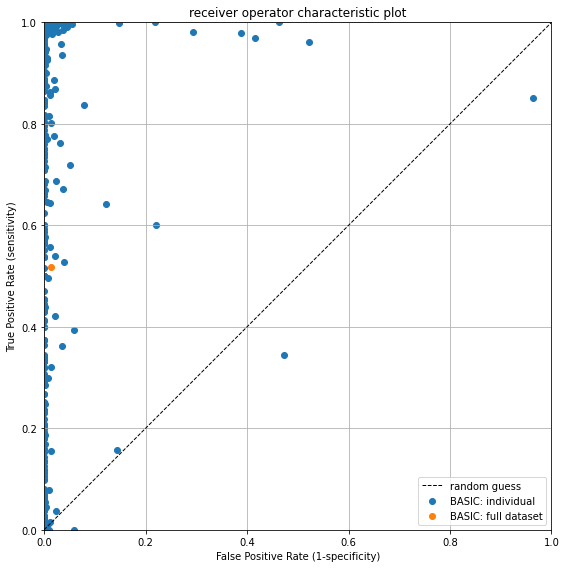

In [12]:
ax = traval.plots.roc_plot(
    [np.array(tpr)], [np.array(fpr)], labels=["BASIC: individual"]
)
traval.plots.roc_plot(
    bc_sum.true_positive_rate,
    bc_sum.false_positive_rate,
    labels="BASIC: full dataset",
    ax=ax,
    plot_diagonal=False,
)

If we check the True Positive Rate we see that it is indeed about 50%:

In [13]:
bc_sum.true_positive_rate

0.517919351213665

Matthews Correlation Coefficient (MCC) for the full dataset. 

The MCC is seen as a balanced measure for classification that also works when classes have very different sizes. It is essentially a measure between -1 and 1 that attempts to summarize the confusion matrix in one value. A coefficient of +1 represents a perfect prediction, 0 no better than random prediction and −1 indicates total disagreement between prediction and observation. Though there is no perfect way of summarizing the confusion matrix in one measure, the MCC is seen as one of the best of such measures (Source: [Wikipedia](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient)).

In [14]:
bc_sum.mcc

0.5340471787404938

Get statistics per comment

In [15]:
summ = None
for d in tqdm(dlist.values()):
    if summ is None:
        summ = d.comparisons[4].compare_to_base_by_comment()
    else:
        summ = summ.add(d.comparisons[4].compare_to_base_by_comment(), fill_value=0.0)

  0%|          | 0/481 [00:00<?, ?it/s]

In [16]:
summ = summ.dropna(how="all", axis=0)
summ

,,drift logger,droog,foute meting,inhang,lucht,onbetrouwbare meting,piek
kept_in_both,24651161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flagged_in_s1,319029.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flagged_in_s2,NaN,299331.0,24234.0,21559.0,9111.0,3361.0,48017.0,6215.0
flagged_in_both,NaN,31367.0,303194.0,23006.0,34652.0,15343.0,24959.0,9923.0


In [17]:
ratio = summ / summ.sum()
ratio

,,drift logger,droog,foute meting,inhang,lucht,onbetrouwbare meting,piek
kept_in_both,0.987224,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flagged_in_s1,0.012776,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flagged_in_s2,NaN,0.905149,0.074013,0.483765,0.20819,0.179694,0.657983,0.385116
flagged_in_both,NaN,0.094851,0.925987,0.516235,0.79181,0.820306,0.342017,0.614884


Plot barchart showing error detection rate per comment.

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


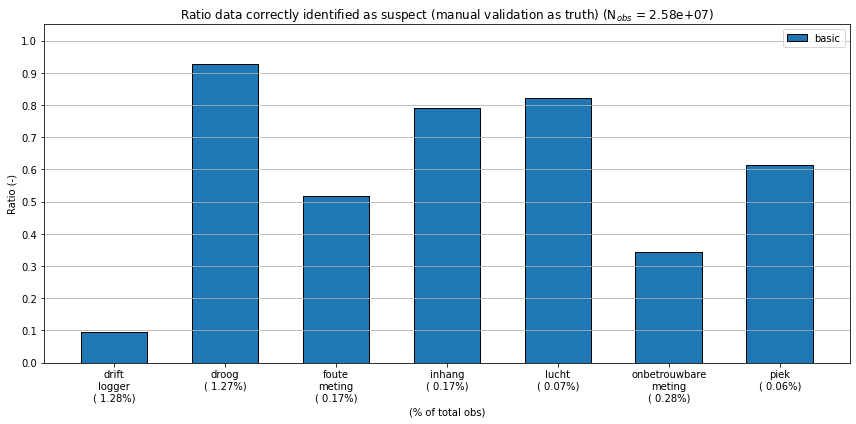

In [18]:
lbls = list(
    (
        ratio.columns.str.replace(" ", "\n")
        + summ.sum().apply(lambda s: "\n({0:>6.2%})".format(s / bc_sum.n_obs))
    ).values
)

# create figure
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

bar = ax.bar(
    range(ratio.columns.size),
    ratio.loc["flagged_in_both"].values,
    align="center",
    width=0.6,
    edgecolor="k",
    label=rset.name,
)

ax.set_xticklabels(lbls)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylabel("Ratio (-)")
ax.grid(True, axis="y")
ax.legend(loc="upper right")
ax.set_title(
    "Ratio data correctly identified as suspect "
    "(manual validation as truth) "
    "(N$_{{obs}}$ = {0:5.2e})".format(summ.sum().sum())
)
plt.xticks(rotation=0, ha="center")
ax.set_ylim(0, 1.05)
ax.set_xlabel("(% of total obs)")

fig.tight_layout()